Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=5, rf__n_estimators=150, ridge__alpha=1.099749158180029, svr__C=46.02488919658672, svr__epsilon=0.04337086111390219; total time=  

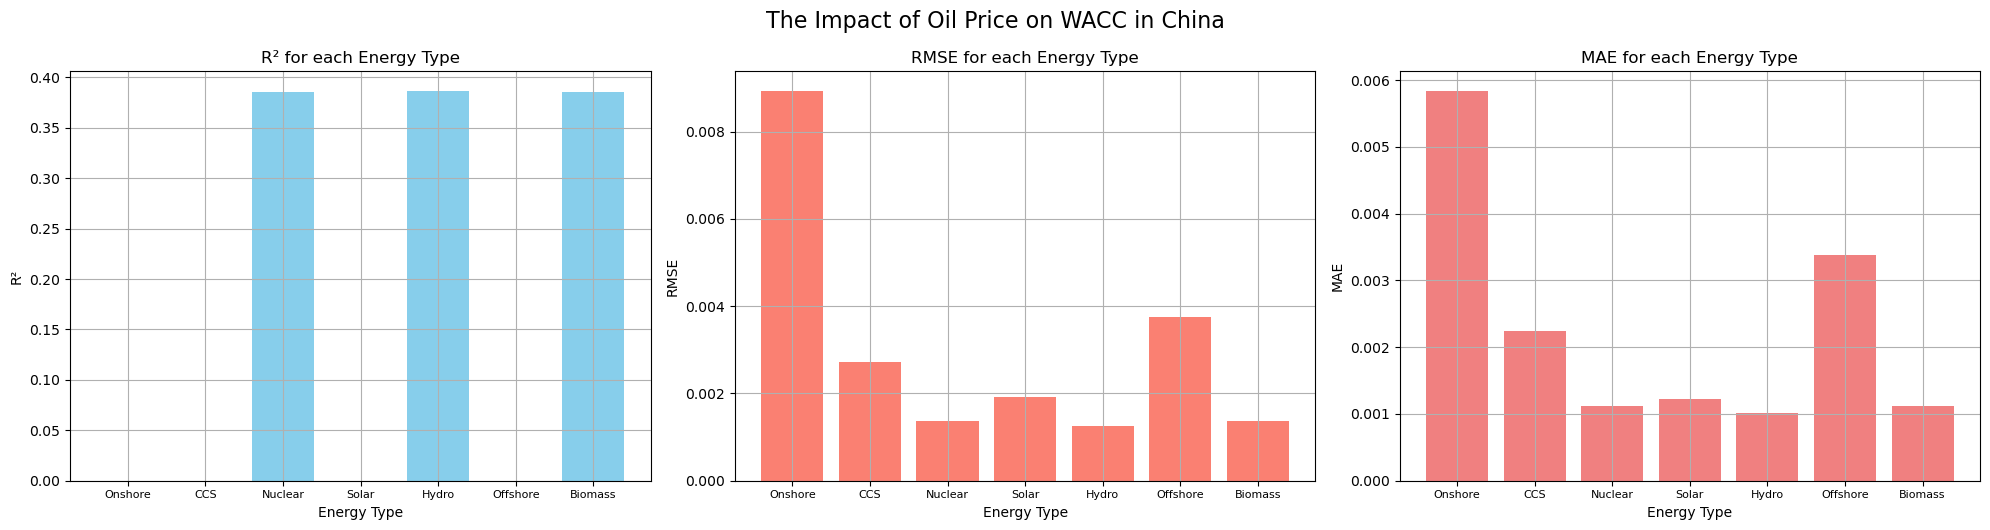

  Energy Type        R²      RMSE       MAE  \
0     Onshore  0.000000  0.008935  0.005838   
1         CCS  0.000000  0.002720  0.002241   
2     Nuclear  0.385051  0.001378  0.001112   
3       Solar  0.000000  0.001925  0.001225   
4       Hydro  0.386675  0.001254  0.001011   
5    Offshore  0.000000  0.003761  0.003379   
6     Biomass  0.385051  0.001378  0.001112   

                                          Best Model  
0  StackingRegressor(estimators=[('ridge', Ridge(...  
1  StackingRegressor(estimators=[('ridge', Ridge(...  
2  StackingRegressor(estimators=[('ridge', Ridge(...  
3  StackingRegressor(estimators=[('ridge', Ridge(...  
4  StackingRegressor(estimators=[('ridge', Ridge(...  
5  StackingRegressor(estimators=[('ridge', Ridge(...  
6  StackingRegressor(estimators=[('ridge', Ridge(...  


In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import uniform

# Load and prepare the data
df = pd.read_excel('China+_WACC_And_Predicted_Price.xlsx', sheet_name='Sheet1')
df = df.sort_values('Year')

# Define energy types
energy_types = ['Onshore', 'CCS', 'Nuclear', 'Solar', 'Hydro', 'Offshore', 'Biomass']

# Store results for each model
results = []

# Use a shared DataFrame for features and targets
X = df[['Oil_Price']]  # Feature: Oil_Price
# Loop over energy types to predict WACC for each energy type
for energy in energy_types:
    y = df[energy]  # Target: WACC for each energy type

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the base models for stacking
    base_learners = [
        ('ridge', Ridge(alpha=1.0)),
        ('dt', DecisionTreeRegressor(max_depth=5)),
        ('svr', SVR(C=1.0, epsilon=0.1)),
        ('knn', KNeighborsRegressor(n_neighbors=5)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]
    
    # Initialize the Stacking Regressor with a Ridge regressor as the final estimator
    stack_regressor = StackingRegressor(estimators=base_learners, final_estimator=LinearRegression())

    # Define parameter grid for RandomizedSearchCV on Stacking Regressor
    param_dist = {
        'ridge__alpha': uniform(0.1, 10),          # Ridge regularization strength
        'dt__max_depth': [3, 5, 7, 9],            # Decision tree depth
        'svr__C': uniform(0.1, 100),              # SVR regularization
        'svr__epsilon': uniform(0.01, 0.1),       # SVR epsilon
        'rf__n_estimators': [50, 100, 150],       # Random forest estimators
    }

    # Perform RandomizedSearchCV for hyperparameter tuning (use all cores for parallelization)
    random_search = RandomizedSearchCV(stack_regressor, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)

    # Predict using the best model
    y_pred = random_search.best_estimator_.predict(X_test)

    # Evaluate the model using R², RMSE, and MAE
    r2 = r2_score(y_test, y_pred)
    
    # If R² is negative, enforce a lower bound of 0 to avoid displaying negative R²
    if r2 < 0:
        r2 = 0  # Prevent negative R² values

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE calculation
    mae = mean_absolute_error(y_test, y_pred)  # MAE calculation

    # Store the results (excluding MSE)
    results.append({
        'Energy Type': energy,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Best Model': random_search.best_estimator_
    })

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot R² values
ax[0].bar(results_df['Energy Type'], results_df['R²'], color='skyblue')
ax[0].set_title('R² for each Energy Type')
ax[0].set_xlabel('Energy Type')
ax[0].set_ylabel('R²')
ax[0].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[0].grid(True)

# Plot RMSE values
ax[1].bar(results_df['Energy Type'], results_df['RMSE'], color='salmon')
ax[1].set_title('RMSE for each Energy Type')
ax[1].set_xlabel('Energy Type')
ax[1].set_ylabel('RMSE')
ax[1].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[1].grid(True)

# Plot MAE values
ax[2].bar(results_df['Energy Type'], results_df['MAE'], color='lightcoral')
ax[2].set_title('MAE for each Energy Type')
ax[2].set_xlabel('Energy Type')
ax[2].set_ylabel('MAE')
ax[2].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[2].grid(True)

# Adjust layout for better presentation
plt.tight_layout()

# Add the main title for the whole figure
plt.suptitle('The Impact of Oil Price on WACC in China', fontsize=16, y=1.05)

# Save the plot as an image file (PNG format)
plt.savefig('The_Impact_of_Oil_Price_on_WACC_in_China_Stacking.png', dpi=300)

# Show the plot
plt.show()

# Print evaluation results for each energy type
print(results_df)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.1s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.1s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=5, rf__n_estimators=150, ridge__alpha=1.099749158180029, svr__C=46.02488919658672, svr__epsilon=0.04337086111390219; total time=  

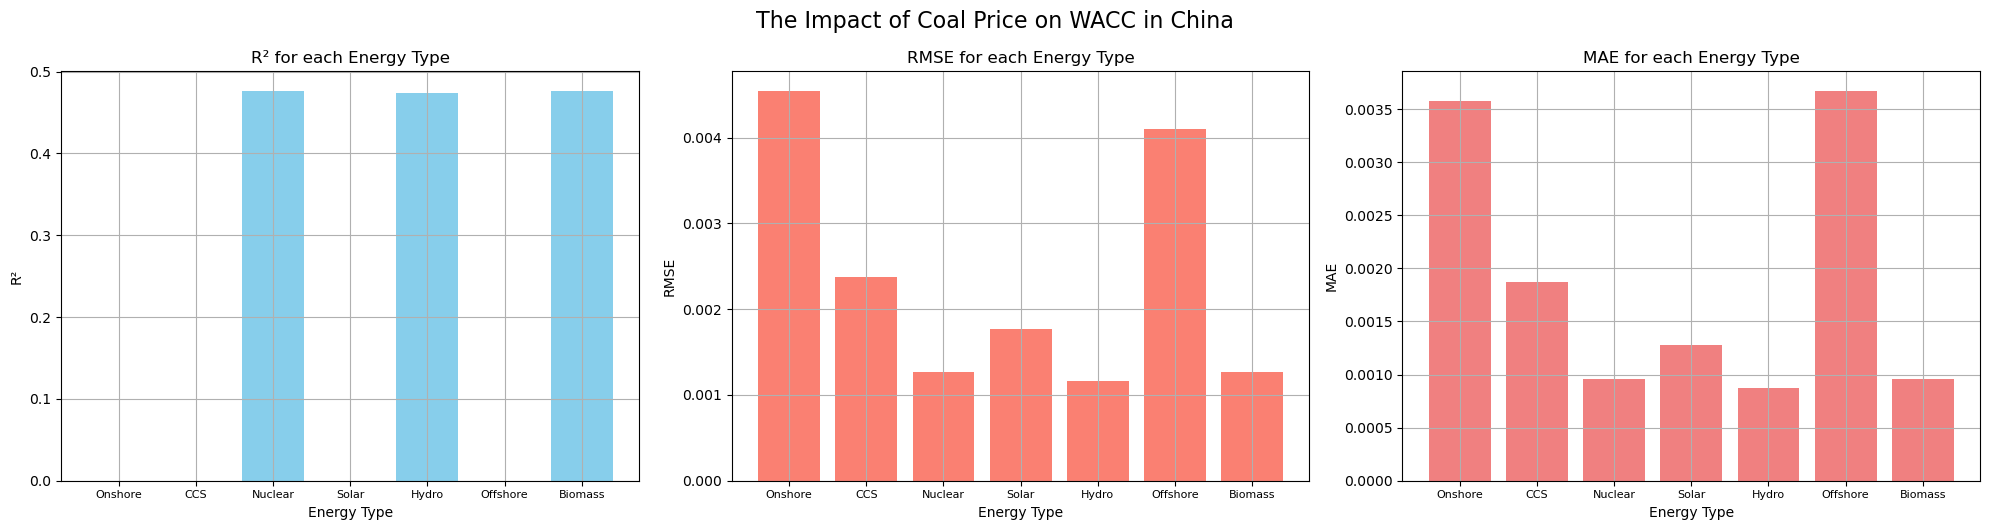

  Energy Type        R²      RMSE       MAE  \
0     Onshore  0.000000  0.004547  0.003579   
1         CCS  0.000000  0.002380  0.001871   
2     Nuclear  0.476485  0.001271  0.000956   
3       Solar  0.000000  0.001768  0.001278   
4       Hydro  0.473736  0.001162  0.000873   
5    Offshore  0.000000  0.004100  0.003673   
6     Biomass  0.476485  0.001271  0.000956   

                                          Best Model  
0  StackingRegressor(estimators=[('ridge', Ridge(...  
1  StackingRegressor(estimators=[('ridge', Ridge(...  
2  StackingRegressor(estimators=[('ridge', Ridge(...  
3  StackingRegressor(estimators=[('ridge', Ridge(...  
4  StackingRegressor(estimators=[('ridge', Ridge(...  
5  StackingRegressor(estimators=[('ridge', Ridge(...  
6  StackingRegressor(estimators=[('ridge', Ridge(...  


In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import uniform

# Load and prepare the data
df = pd.read_excel('China+_WACC_And_Predicted_Price.xlsx', sheet_name='Sheet1')
df = df.sort_values('Year')

# Define energy types
energy_types = ['Onshore', 'CCS', 'Nuclear', 'Solar', 'Hydro', 'Offshore', 'Biomass']

# Store results for each model
results = []

# Use a shared DataFrame for features and targets
X = df[['Coal_Price']]  # Feature: Coal_Price
# Loop over energy types to predict WACC for each energy type
for energy in energy_types:
    y = df[energy]  # Target: WACC for each energy type

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the base models for stacking
    base_learners = [
        ('ridge', Ridge(alpha=1.0)),
        ('dt', DecisionTreeRegressor(max_depth=5)),
        ('svr', SVR(C=1.0, epsilon=0.1)),
        ('knn', KNeighborsRegressor(n_neighbors=5)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]
    
    # Initialize the Stacking Regressor with a Ridge regressor as the final estimator
    stack_regressor = StackingRegressor(estimators=base_learners, final_estimator=LinearRegression())

    # Define parameter grid for RandomizedSearchCV on Stacking Regressor
    param_dist = {
        'ridge__alpha': uniform(0.1, 10),          # Ridge regularization strength
        'dt__max_depth': [3, 5, 7, 9],            # Decision tree depth
        'svr__C': uniform(0.1, 100),              # SVR regularization
        'svr__epsilon': uniform(0.01, 0.1),       # SVR epsilon
        'rf__n_estimators': [50, 100, 150],       # Random forest estimators
    }

    # Perform RandomizedSearchCV for hyperparameter tuning (use all cores for parallelization)
    random_search = RandomizedSearchCV(stack_regressor, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)

    # Predict using the best model
    y_pred = random_search.best_estimator_.predict(X_test)

    # Evaluate the model using R², RMSE, and MAE
    r2 = r2_score(y_test, y_pred)
    
    # If R² is negative, enforce a lower bound of 0 to avoid displaying negative R²
    if r2 < 0:
        r2 = 0  # Prevent negative R² values

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE calculation
    mae = mean_absolute_error(y_test, y_pred)  # MAE calculation

    # Store the results (excluding MSE)
    results.append({
        'Energy Type': energy,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Best Model': random_search.best_estimator_
    })

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot R² values
ax[0].bar(results_df['Energy Type'], results_df['R²'], color='skyblue')
ax[0].set_title('R² for each Energy Type')
ax[0].set_xlabel('Energy Type')
ax[0].set_ylabel('R²')
ax[0].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[0].grid(True)

# Plot RMSE values
ax[1].bar(results_df['Energy Type'], results_df['RMSE'], color='salmon')
ax[1].set_title('RMSE for each Energy Type')
ax[1].set_xlabel('Energy Type')
ax[1].set_ylabel('RMSE')
ax[1].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[1].grid(True)

# Plot MAE values
ax[2].bar(results_df['Energy Type'], results_df['MAE'], color='lightcoral')
ax[2].set_title('MAE for each Energy Type')
ax[2].set_xlabel('Energy Type')
ax[2].set_ylabel('MAE')
ax[2].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[2].grid(True)

# Adjust layout for better presentation
plt.tight_layout()

# Add the main title for the whole figure
plt.suptitle('The Impact of Coal Price on WACC in China', fontsize=16, y=1.05)

# Save the plot as an image file (PNG format)
plt.savefig('The_Impact_of_Coal_Price_on_WACC_in_China_Stacking.png', dpi=300)

# Show the plot
plt.show()

# Print evaluation results for each energy type
print(results_df)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.2s
[CV] END dt__max_depth=7, rf__n_estimators=50, ridge__alpha=1.934347898661638, svr__C=78.06910002727692, svr__epsilon=0.0696850157946487; total time=   0.3s
[CV] END dt__max_depth=5, rf__n_estimators=150, ridge__alpha=1.099749158180029, svr__C=46.02488919658672, svr__epsilon=0.04337086111390219; total time=  

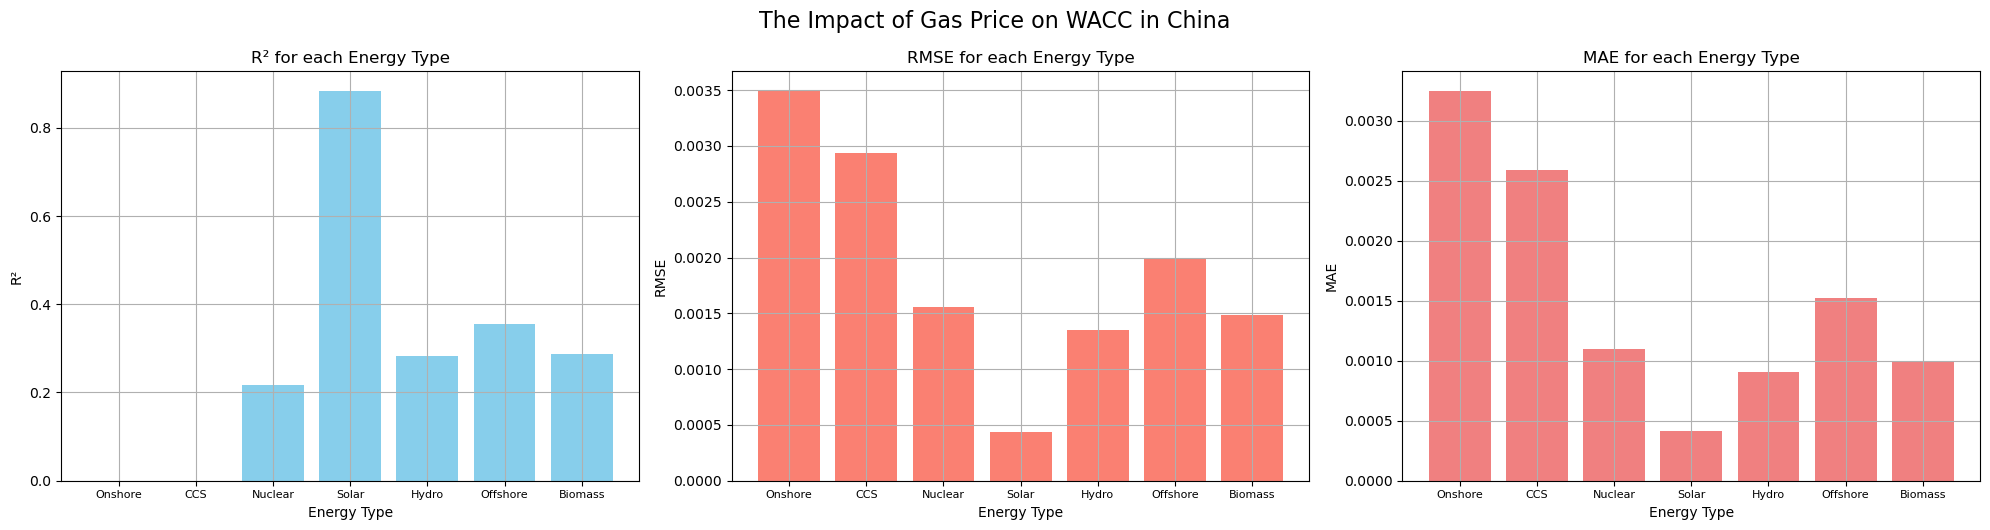

  Energy Type        R²      RMSE       MAE  \
0     Onshore  0.000000  0.003494  0.003247   
1         CCS  0.000000  0.002940  0.002592   
2     Nuclear  0.216840  0.001555  0.001096   
3       Solar  0.883882  0.000441  0.000411   
4       Hydro  0.283665  0.001355  0.000909   
5    Offshore  0.354631  0.001990  0.001523   
6     Biomass  0.287711  0.001483  0.000996   

                                          Best Model  
0  StackingRegressor(estimators=[('ridge', Ridge(...  
1  StackingRegressor(estimators=[('ridge', Ridge(...  
2  StackingRegressor(estimators=[('ridge', Ridge(...  
3  StackingRegressor(estimators=[('ridge', Ridge(...  
4  StackingRegressor(estimators=[('ridge', Ridge(...  
5  StackingRegressor(estimators=[('ridge', Ridge(...  
6  StackingRegressor(estimators=[('ridge', Ridge(...  


In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import uniform

# Load and prepare the data
df = pd.read_excel('China+_WACC_And_Predicted_Price.xlsx', sheet_name='Sheet1')
df = df.sort_values('Year')

# Define energy types
energy_types = ['Onshore', 'CCS', 'Nuclear', 'Solar', 'Hydro', 'Offshore', 'Biomass']

# Store results for each model
results = []

# Use a shared DataFrame for features and targets
X = df[['Gas_Price']]  # Feature: Gas_Price
# Loop over energy types to predict WACC for each energy type
for energy in energy_types:
    y = df[energy]  # Target: WACC for each energy type

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the base models for stacking
    base_learners = [
        ('ridge', Ridge(alpha=1.0)),
        ('dt', DecisionTreeRegressor(max_depth=5)),
        ('svr', SVR(C=1.0, epsilon=0.1)),
        ('knn', KNeighborsRegressor(n_neighbors=5)),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]
    
    # Initialize the Stacking Regressor with a Ridge regressor as the final estimator
    stack_regressor = StackingRegressor(estimators=base_learners, final_estimator=LinearRegression())

    # Define parameter grid for RandomizedSearchCV on Stacking Regressor
    param_dist = {
        'ridge__alpha': uniform(0.1, 10),          # Ridge regularization strength
        'dt__max_depth': [3, 5, 7, 9],            # Decision tree depth
        'svr__C': uniform(0.1, 100),              # SVR regularization
        'svr__epsilon': uniform(0.01, 0.1),       # SVR epsilon
        'rf__n_estimators': [50, 100, 150],       # Random forest estimators
    }

    # Perform RandomizedSearchCV for hyperparameter tuning (use all cores for parallelization)
    random_search = RandomizedSearchCV(stack_regressor, param_distributions=param_dist, n_iter=50, cv=5,
                                       scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)

    # Predict using the best model
    y_pred = random_search.best_estimator_.predict(X_test)

    # Evaluate the model using R², RMSE, and MAE
    r2 = r2_score(y_test, y_pred)
    
    # If R² is negative, enforce a lower bound of 0 to avoid displaying negative R²
    if r2 < 0:
        r2 = 0  # Prevent negative R² values

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE calculation
    mae = mean_absolute_error(y_test, y_pred)  # MAE calculation

    # Store the results (excluding MSE)
    results.append({
        'Energy Type': energy,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Best Model': random_search.best_estimator_
    })

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot R² values
ax[0].bar(results_df['Energy Type'], results_df['R²'], color='skyblue')
ax[0].set_title('R² for each Energy Type')
ax[0].set_xlabel('Energy Type')
ax[0].set_ylabel('R²')
ax[0].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[0].grid(True)

# Plot RMSE values
ax[1].bar(results_df['Energy Type'], results_df['RMSE'], color='salmon')
ax[1].set_title('RMSE for each Energy Type')
ax[1].set_xlabel('Energy Type')
ax[1].set_ylabel('RMSE')
ax[1].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[1].grid(True)

# Plot MAE values
ax[2].bar(results_df['Energy Type'], results_df['MAE'], color='lightcoral')
ax[2].set_title('MAE for each Energy Type')
ax[2].set_xlabel('Energy Type')
ax[2].set_ylabel('MAE')
ax[2].tick_params(axis='x', labelsize=8)  # Adjust font size for x-axis labels
ax[2].grid(True)

# Adjust layout for better presentation
plt.tight_layout()

# Add the main title for the whole figure
plt.suptitle('The Impact of Gas Price on WACC in China', fontsize=16, y=1.05)

# Save the plot as an image file (PNG format)
plt.savefig('The_Impact_of_Gas_Price_on_WACC_in_China_Stacking.png', dpi=300)

# Show the plot
plt.show()

# Print evaluation results for each energy type
print(results_df)
